In [1]:
import os
import sys

sys.path.append('../txf_design-space/')
sys.path.append('../txf_design-space/flexibert')
sys.path.append('../protran/boshnas/boshnas/')
sys.path.append('../global_search/utils')
sys.path.append('../')

import re
import yaml
import json
import time
import torch
import shlex
import shutil
import argparse
import subprocess
import collections
import itertools
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt
from six.moves import cPickle as pickle

from embeddings.utils import graph_util, print_util as pu

sys.path.append('../txf_design-space/transformers/src/transformers')
import embedding_util

from boshnas import BOSHNAS
from boshnas_2inp import BOSHNAS as BOSHCODE
from acq import gosh_acq as acq

from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular, BertForSequenceClassificationModular

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge, LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, ndcg_score

from six.moves import cPickle as pickle
from scipy.interpolate import griddata
from sklearn.tree import plot_tree
from scipy.optimize import minimize, differential_evolution

from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from skopt.plots import plot_convergence

import lightgbm

PREFIX_CHECKPOINT_DIR = "checkpoint"

In [2]:
# Toggles and constants
K_PRETRAIN = 0.5; K_GLUE = 0.5; K_LATENCY = 0.2; K_ENERGY = 0.2; K_PEAK_POWER = 0.1
MAX_PRETRAIN = 4; MAX_GLUE = 1; MAX_LATENCY = 1000; MAX_ENERGY = 2000; MAX_PEAK_POWER = 300
PERFORMANCE_PATIENCE = 5
RANDOM_SAMPLES = 100
K = 10

In [3]:
# Load surrogate models for glue score and pre-train loss
gbdtr = pickle.load(open('../global_search/dataset/surrogate_models/glue.pkl', 'rb'))
gbdtr_loss = pickle.load(open('../global_search/dataset/surrogate_models/pretrain.pkl', 'rb'))

# Prepare stochastic surrogate model
def predict_fn(gbdtr, X):
    mean = float(gbdtr.predict(X))
    dt_preds = []
    for estimator in gbdtr.estimators_:
        pred = estimator[0].predict(X)
        dt_preds.append(pred)
    std = float(np.std(np.array(dt_preds)))
    return float(np.random.normal(mean, std))

In [4]:
# Create a dataset of transformer-device pairs (from common initial Sobol samples and predicted accuracies)
devices = ['a100', 'cpu_m1-pro', 'gpu_m1-pro', 'cpu_rpi', 'npu_ncs', 'cpu_jetson-nano', 'gpu_jetson-nano']
device_names = ['A100', 'Apple M1 CPU', 'Apple M1 GPU', 'Raspberry Pi CPU', 'Intel NCS NPU', 'Jetson Nano CPU', 
           'Jetson Nano GPU']
device_dirs = ['results_gpu_a100_b128_r3', 'results_cpu_m1-pro_b32_r1', 'results_gpu_m1-pro_b32_r3',
                'results_cpu_rpi_b1_r1', 'results_npu_ncs_b1_r1', 'results_cpu_jetson-nano_b1_r1',
                'results_gpu_jetson-nano_b1_r1']

# Dataset for transformer pre-train loss
dataset_txf = json.load(open('../global_search/dataset/dataset.json'))
dataset = {}

# Surrogate model for pre-train loss
gbdtr = pickle.load(open('../global_search/dataset/surrogate_models/glue.pkl', 'rb'))

for i, device_dir in enumerate(device_dirs):
    dataset_device = json.load(
        open(f'../protran/energy_profiler/results/{device_dir}/dataset/dataset.json', 'r'))
    for model in dataset_device.keys():
        pair = model + '_' + devices[i]
        dataset[pair] = deepcopy(dataset_device[model])
        dataset[pair]['embedding_txf'] = dataset_device[model]['embedding']; del dataset[pair]['embedding']
        embedding_device = [0 for _ in devices]; embedding_device[i] = 1
        dataset[pair]['embedding_device'] = str(embedding_device)
        if model in dataset_txf.keys() and dataset_txf[model]['pretrain']['loss'] is not None and \
            dataset_txf[model]['pretrain']['loss'] < 7:
            dataset[pair]['performance']['pretrain_loss'] = dataset_txf[model]['pretrain']['loss']
        else:
            dataset[pair]['performance']['pretrain_loss'] = \
                float(predict_fn(gbdtr_loss, np.array(eval(dataset[pair]['embedding_txf'])).reshape(1, -1)))
        if model in dataset_txf.keys() and dataset_txf[model]['glue'] is not None:
            dataset[pair]['performance']['glue'] = eval(dataset_txf[model]['glue'])
        else:
            dataset[pair]['performance']['glue'] = \
                float(predict_fn(gbdtr, np.array(eval(dataset[pair]['embedding_txf'])).reshape(1, -1)))
        
print(f'Co-design dataset created of size: {len(dataset)}')

if not os.path.exists('../co-design/dataset/dataset.json'):
    json.dump(dataset, open('../co-design/dataset/dataset.json', 'w+'))
    print('Saved co-design dataset')
else:
    dataset = json.load(open('../co-design/dataset/dataset.json', 'r'))
    print('Loaded co-design dataset')

Co-design dataset created of size: 782
Loaded co-design dataset


In [5]:
# Convert dataset to tabular format
X_txf, X_device, y_pretrain, y_glue, y_latency, y_energy, y_peak_power = [], [], [], [], [], [], []
for pair in dataset.keys():
    X_txf.append(eval(dataset[pair]['embedding_txf']))
    X_device.append(eval(dataset[pair]['embedding_device']))
    y_pretrain.append(dataset[pair]['performance']['pretrain_loss'])
    y_glue.append(dataset[pair]['performance']['glue'])
    y_latency.append(dataset[pair]['performance']['latency'])
    y_energy.append(dataset[pair]['performance']['energy'])
    y_peak_power.append(dataset[pair]['performance']['peak_power'])
    
X_txf, X_device = np.array(X_txf), np.array(X_device)
    
# Get performance bounds
print(f'Min. pre-train loss: {min(y_pretrain) : 0.3f}. \tMax. pre-train loss: {max(y_pretrain) : 0.3f}')
print(f'Min. GLUE score: {min(y_glue) : 0.3f}. \tMax. GLUE score: {max(y_glue) : 0.3f}')
print(f'Min. latency: {min(y_latency) : 0.3f}. \t\tMax. latency: {max(y_latency) : 0.3f}')
print(f'Min. energy: {min(y_energy) : 0.3f}. \t\tMax. energy: {max(y_energy) : 0.3f}')
print(f'Min. peak power: {min(y_peak_power) : 0.3f}. \tMax. peak power: {max(y_peak_power) : 0.3f}')

# Get input bounds
bounds_device = (np.min(X_device, axis=0), np.max(X_device, axis=0))
design_space = yaml.safe_load(open('../global_search/design_space/design_space.yaml'))
bounds_txf = embedding_util.get_embedding_bounds(design_space, 'all')
bounds_txf = (np.array([bound[0] for bound in bounds_txf]), \
                    np.array([bound[1] for bound in bounds_txf]))

# Get convex combination output
y = []
for i in range(len(y_glue)):
    performance = K_GLUE * (y_glue[i] / MAX_GLUE) + \
                  K_LATENCY * (1 - y_latency[i] / MAX_LATENCY) + \
                  K_ENERGY * (1 - y_energy[i] / MAX_ENERGY) + \
                  K_PEAK_POWER * (1 - y_peak_power[i] / MAX_PEAK_POWER)
    y.append(1 - performance)
    
y = np.array(y)

Min. pre-train loss:  2.050. 	Max. pre-train loss:  3.586
Min. GLUE score:  0.703. 	Max. GLUE score:  0.838
Min. latency:  0.003. 		Max. latency:  814.751
Min. energy:  0.042. 		Max. energy:  1864.779
Min. peak power:  2.008. 	Max. peak power:  282.700


Training NPN model: 100%|██████████| 200/200 [13:32<00:00,  4.06s/it]


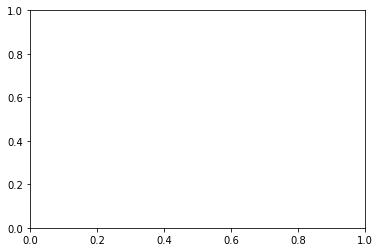

In [8]:
# Train BOSHCODE on HW-SW dataset
ckpt_exists = os.path.exists('../co-design/dataset/surrogate_model/teacher.ckpt')
surrogate_model = BOSHCODE(input_dim1=X_txf.shape[1],
                           input_dim2=X_device.shape[1],
                           bounds1=bounds_txf,
                           bounds2=bounds_device,
                           trust_region=False,
                           second_order=True,
                           parallel=True,
                           model_aleatoric=True,
                           save_path='../co-design/dataset/surrogate_model/',
                           pretrained=ckpt_exists)

max_loss = np.amax(y)
y = y/max_loss

if not ckpt_exists: train_error = surrogate_model.train(X_txf, X_device, y)

In [6]:
# Load surrogate models for latency, energy and peak power
latency_models = [pickle.load(
    open(f'../protran/energy_profiler/results/{device_dir}/dataset/surrogate_models/latency.pkl', 'rb')) \
    for device_dir in device_dirs] 
energy_models = [pickle.load(
    open(f'../protran/energy_profiler/results/{device_dir}/dataset/surrogate_models/energy.pkl', 'rb')) \
    for device_dir in device_dirs] 
peak_power_models = [pickle.load(
    open(f'../protran/energy_profiler/results/{device_dir}/dataset/surrogate_models/peak_power.pkl', 'rb')) \
    for device_dir in device_dirs] 
max_values = [json.load(
    open(f'../protran/energy_profiler/results/{device_dir}/dataset/surrogate_models/max_values.json', 'rb')) \
    for device_dir in device_dirs] 

# Prepare stochastic surrogate model
def predict_hw_performance(latency_models, energy_models, peak_power_models, max_values, X_txf, X_device):
    assert X_device.shape[0] == 1
    device_idx = int(np.argmax(np.squeeze(X_device)))
    latency_mean = float(latency_models[device_idx].predict(X_txf) * max_values[device_idx]['max_latency'])
    energy_mean = float(energy_models[device_idx].predict(X_txf) * max_values[device_idx]['max_energy'])
    peak_power_mean = float(peak_power_models[device_idx].predict(X_txf) * max_values[device_idx]['max_peak_power'])
    latency_preds, energy_preds, peak_power_preds = [], [], []
    for latency_estimator, energy_estimator, peak_power_estimator in \
    zip(latency_models[device_idx].estimators_, energy_models[device_idx].estimators_, \
    peak_power_models[device_idx].estimators_):
        latency_preds.append(latency_estimator.predict(X_txf) * max_values[device_idx]['max_latency'])
        energy_preds.append(energy_estimator.predict(X_txf) * max_values[device_idx]['max_energy'])
        peak_power_preds.append(peak_power_estimator.predict(X_txf) * max_values[device_idx]['max_peak_power'])
    latency_std = float(np.std(np.array(latency_preds)))
    energy_std = float(np.std(np.array(energy_preds)))
    peak_power_std = float(np.std(np.array(peak_power_preds)))
    return float(np.random.normal(latency_mean, latency_std)), float(np.random.normal(energy_mean, energy_std)), \
        float(np.random.normal(peak_power_mean, peak_power_std))

In [7]:
# Get random samples for devices
def get_device_samples(num_devices, num_samples):
    samples = []
    for _ in range(num_samples):
        device_idx = np.random.randint(num_devices)
        device = np.zeros(num_devices)
        device[device_idx] = 1
        samples.append(device)
    return samples

In [102]:
# Get y (1 - performance) to minimize
def get_y(x):
    x_txf, x_device = x[:37], x[37:]
    x_txf = x_txf
    if sum(x_device) != 1:
        return 100
    if not embedding_util.is_valid_embedding(x_txf, design_space):
        return 100
    x_txf = np.array(x_txf).reshape(1, -1)
    device_idx = int(np.argmax(np.squeeze(x_device)))
    latency_mean = float(latency_models[device_idx].predict(x_txf) * max_values[device_idx]['max_latency'])
    energy_mean = float(energy_models[device_idx].predict(x_txf) * max_values[device_idx]['max_energy'])
    peak_power_mean = float(peak_power_models[device_idx].predict(x_txf) * max_values[device_idx]['max_peak_power'])
    latency_preds, energy_preds, peak_power_preds = [], [], []
    for latency_estimator, energy_estimator, peak_power_estimator in \
    zip(latency_models[device_idx].estimators_, energy_models[device_idx].estimators_, \
    peak_power_models[device_idx].estimators_):
        latency_preds.append(latency_estimator.predict(x_txf) * max_values[device_idx]['max_latency'])
        energy_preds.append(energy_estimator.predict(x_txf) * max_values[device_idx]['max_energy'])
        peak_power_preds.append(peak_power_estimator.predict(x_txf) * max_values[device_idx]['max_peak_power'])
    latency_std = float(np.std(np.array(latency_preds)))/10.0
    energy_std = float(np.std(np.array(energy_preds)))/10.0
    peak_power_std = float(np.std(np.array(peak_power_preds)))/10.0
    y_latency, y_energy, y_peak_power = float(np.random.normal(latency_mean, latency_std)), float(np.random.normal(energy_mean, energy_std)), \
        float(np.random.normal(peak_power_mean, peak_power_std))
    y_glue = predict_fn(gbdtr, x_txf)
    print(f'GLUE score: {y_glue * 100 : 0.2f}, Latency: {y_latency: 0.2f}s/seq, Energy: {y_energy : 0.2f}J/seq, Peak power: {y_peak_power : 0.2f}W')
    performance = K_GLUE * (y_glue / MAX_GLUE) + \
                  K_LATENCY * (1 - y_latency / MAX_LATENCY) + \
                  K_ENERGY * (1 - y_energy / MAX_ENERGY) + \
                  K_PEAK_POWER * (1 - y_peak_power / MAX_PEAK_POWER)
    return 1 - performance

In [ ]:
# Run GP minimization
bounds = []
for i in range(len(bounds_txf[0])):
    bounds.append((bounds_txf[0][i], bounds_txf[1][i]))
for i in range(len(bounds_device[0])):
    bounds.append((bounds_device[0][i], bounds_device[1][i]))
res = gp_minimize(get_y,
                 bounds,
                 x0=np.concatenate((X_txf, X_device), axis=1).tolist(),
                 y0=y.tolist(),
                 n_initial_points=10,
                 n_calls=100,
                 random_state=10,
                 n_jobs=8,
                 verbose=True)

In [ ]:
# Run co-design with exploration on random samples
random_samples = embedding_util.get_samples(design_space, 
                                            num_samples=RANDOM_SAMPLES, 
                                            sampling_method='Random', 
                                            debug=False)

best_performance, old_best_performance, same_performance, itn = np.amin(y), np.inf, 0, 0
while same_performance < PERFORMANCE_PATIENCE:
    random_txf_samples = embedding_util.get_samples(design_space, 
                                            num_samples=RANDOM_SAMPLES, 
                                            sampling_method='Random', 
                                            debug=False)
    random_txf_samples = [random_txf_samples[model]['embedding'] for model in random_txf_samples.keys()]
    random_device_samples = get_device_samples(num_devices=len(devices), num_samples=RANDOM_SAMPLES)
    
    random_samples = [(np.array(random_txf_samples[i]), 
                       random_device_samples[i]) for i in range(len(random_txf_samples))]
    
    # Get queries using GOBI
    query_indices = surrogate_model.get_queries(x=random_samples, k=K, explore_type='ucb', use_al=True)
    
    for i in set(query_indices):
        X_txf_new, X_device_new = random_samples[i]
        y_glue_new = predict_score(gbdtr, X_txf_new.reshape(1, -1))
        y_latency_new, y_energy_new, y_peak_power_new = predict_hw_performance(latency_models, energy_models, 
                                                            peak_power_models, max_values, 
                                                            X_txf_new.reshape(1, -1), X_device_new.reshape(1, -1))
        performance = K_GLUE * (y_glue_new / MAX_GLUE) + \
                  K_LATENCY * (1 - y_latency_new / MAX_LATENCY) + \
                  K_ENERGY * (1 - y_energy_new / MAX_ENERGY) + \
                  K_PEAK_POWER * (1 - y_peak_power_new / MAX_PEAK_POWER)
        
        y_new = np.array([1 - performance])
        y = np.concatenate((y, y_new))
        
        X_txf, X_device = np.concatenate((X_txf, X_txf_new.reshape(1, -1))), \
            np.concatenate((X_device, X_device_new.reshape(1, -1)))
    
    best_performance = np.amin(y)
    print(f'Current iteration: {itn}. \tBest performance: {best_performance}')
    
    # Update same_performance to check convergence
    if best_performance == old_best_performance:
        same_performance += 1

    old_best_performance = best_performance
    
    # Train model on expanded dataset
    train_error = surrogate_model.train(X_txf, X_device, y)